In [1]:
import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits
from astropy.stats import sigma_clipped_stats

from photutils.isophote import EllipseGeometry, Ellipse

# Bring these later when you fit & derive totals:
# from scipy.optimize import curve_fit
# from scipy.special import gamma

# Optional, import *inside* the display cell only if used:
# from astropy.visualization import ZScaleInterval, ImageNormalize
# from photutils.segmentation import detect_threshold, detect_sources


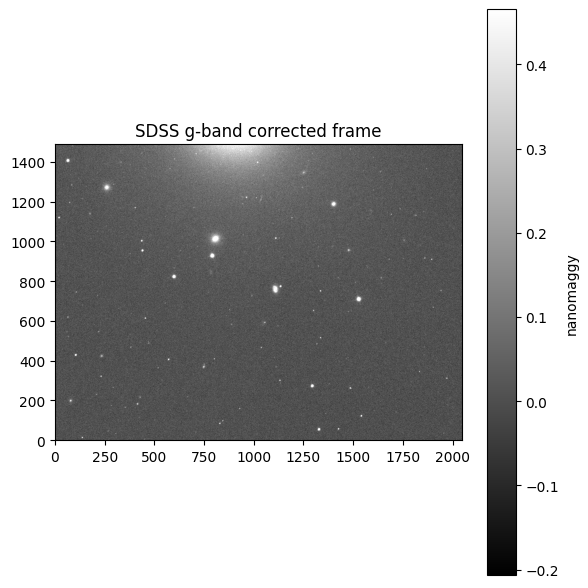

In [2]:
from astropy.visualization import ZScaleInterval, ImageNormalize  # local import for this cell only

# load data + header
img = fits.getdata("C:/Users/andre/Desktop/Astro/GalacticAstronomy/SurfaceBrightnessProfile/frame-g-002168-5-0147.fits").astype(np.float32)
hdr = fits.getheader("C:/Users/andre/Desktop/Astro/GalacticAstronomy/SurfaceBrightnessProfile/frame-g-002168-5-0147.fits")

# optional: pull units for labeling if available
bunit = hdr.get('BUNIT', 'flux per pixel')

# quick display with zscale
norm = ImageNormalize(img, interval=ZScaleInterval())
plt.figure(figsize=(6, 6))
plt.imshow(img, origin='lower', cmap='gray', norm=norm)
plt.title("SDSS g-band corrected frame")
plt.colorbar(label=bunit)
plt.tight_layout()
plt.show()


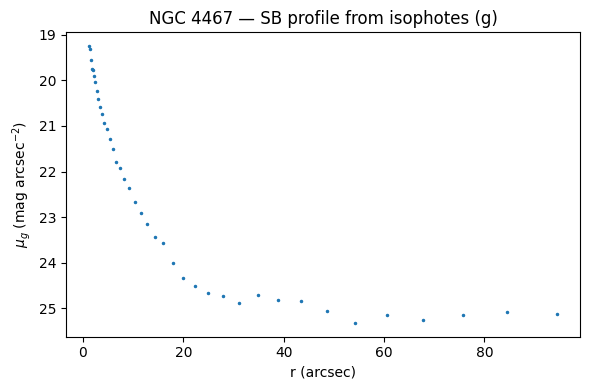

In [3]:
# === CELL A (isophotes): background, isophote fit → SB profile ===
import numpy as np
import matplotlib.pyplot as plt
from astropy.stats import sigma_clipped_stats
from photutils.isophote import EllipseGeometry, Ellipse
from photutils.aperture import EllipticalAnnulus  # only for a fallback if fit fails

# 1) background & background-subtracted image
bkg_mean, bkg_median, bkg_rms = sigma_clipped_stats(img, sigma=3.0, maxiters=5)
img_sub = img - bkg_median

# 2) pixel scale and manual starting center (from your zoom)
s = 0.396          # arcsec/pixel
x0, y0 = 805.0, 1012.0

# 3) define radius range
h, w = img_sub.shape
r_min_pix = max(3, int(np.ceil(1.0/s)))                      # > 1"
r_edge    = int(min(x0, y0, (w-1)-x0, (h-1)-y0))             # nearest border
r_max_pix = max(r_min_pix+3, min(int(np.floor(100.0/s)), r_edge-3))

# 4) try an isophote fit (robustly clipped)
geom = EllipseGeometry(x0=x0, y0=y0, sma=r_min_pix, eps=0.15, pa=0.0)
ellipse = Ellipse(img_sub, geometry=geom)

isolist = None
try:
    # sclip/nclip do sigma-clipping along each isophote to suppress stars
    isolist = ellipse.fit_image(minsma=r_min_pix, maxsma=r_max_pix,
                                step=1.10, linear=False, sclip=3.0, nclip=2)
    # if too few isophotes were fit, pretend it failed
    if (isolist is None) or (len([iso for iso in isolist]) < 12):
        isolist = None
except Exception:
    isolist = None

# 5) extract profile (with a small, version-proof fallback if fit failed)
if isolist is not None:
    sma_pix   = np.array([iso.sma    for iso in isolist], dtype=float)     # pixels
    intens_pix= np.array([iso.intens for iso in isolist], dtype=float)     # nMgy/pix
    eps_arr   = np.array([getattr(iso, 'eps', np.nan) for iso in isolist], dtype=float)
    pa_arr    = np.array([getattr(iso, 'pa',  np.nan) for iso in isolist], dtype=float)
    # representative geometry around Re: median over the fit range
    eps_med = np.nanmedian(eps_arr)
    q = float(1.0 - (eps_med if np.isfinite(eps_med) else 0.15))
    theta = float(np.nanmedian(pa_arr)) if np.isfinite(np.nanmedian(pa_arr)) else 0.0
else:
    # FALLBACK: fixed annuli sampling (kept minimal)
    nbins = 40
    edges = np.geomspace(r_min_pix, r_max_pix, nbins + 1)
    sma_pix = np.sqrt(edges[:-1] * edges[1:])
    q, theta = 0.85, 0.0
    intens = []
    for a_in, a_out in zip(edges[:-1], edges[1:]):
        ann = EllipticalAnnulus((x0, y0), a_in=a_in, a_out=a_out,
                                b_in=q*a_in, b_out=q*a_out, theta=theta)
        am = ann.to_mask(method='center'); am = am[0] if isinstance(am, list) else am
        cut = am.cutout(img_sub)
        if cut is None:
            intens.append(np.nan); continue
        vals = cut[am.data > 0]; vals = vals[np.isfinite(vals)]
        if vals.size < 5:
            intens.append(np.nan); continue
        hi = np.nanpercentile(vals, 95.0)
        intens.append(float(np.nanmedian(vals[vals <= hi])))
    intens_pix = np.asarray(intens, dtype=float)

# 6) clean & convert to μ(r)
good = np.isfinite(intens_pix) & (intens_pix > 0)
sma_pix   = sma_pix[good]
intens_pix= intens_pix[good]

r_arcsec = sma_pix * s
I_as2    = intens_pix / (s**2)                       # nMgy/arcsec^2
mu       = 22.5 - 2.5*np.log10(I_as2)

# quick look (standard orientation: brighter on top)
plt.figure(figsize=(6,4))
plt.plot(r_arcsec, mu, '.', ms=3)
plt.gca().invert_yaxis()
plt.xlabel('r (arcsec)'); plt.ylabel(r'$\mu_g$ (mag arcsec$^{-2}$)')
plt.title('NGC 4467 — SB profile from isophotes (g)')
plt.tight_layout(); plt.show()


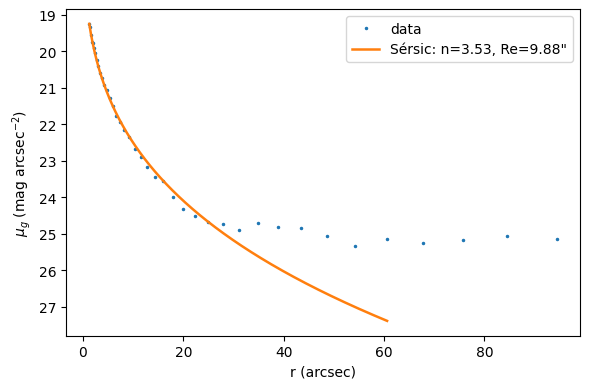

In [4]:
# === CELL B: S/N–gated Sérsic fit (linear units) + overlay ===
from scipy.optimize import curve_fit

def b_n(n):
    return 2*n - 1/3 + 4/(405*n) + 46/(25515*n*n)

def sersic_I(r, Ie, Re, n):
    return Ie * np.exp(-b_n(n) * ((r/Re)**(1/n) - 1))

# Rough S/N per isophote using annulus area as proxy for #pixels contributing
# (works for both real isophotes and the fallback annuli)
edges_like = np.concatenate([[sma_pix[0] / np.sqrt(1.10)], np.sqrt(sma_pix[:-1]*sma_pix[1:]), [sma_pix[-1]*np.sqrt(1.10)]])
# turn centers+edges into approximate in/out radii per bin
a_in  = edges_like[:-1]
a_out = edges_like[1:]
Npix  = np.pi * (1.0 if 'q' not in globals() else q) * (a_out**2 - a_in**2)  # ≈ ellipse area difference
snr   = (intens_pix) / (bkg_rms / np.sqrt(np.maximum(Npix, 1.0)))

# Fit only where reliable: r>1", S/N≥3, and trim outer 10% of radii
fit_mask = (r_arcsec > 1.0) & (snr >= 3) & (r_arcsec < np.percentile(r_arcsec, 90))
x = r_arcsec[fit_mask]; y = I_as2[fit_mask]
if x.size < 8:
    fit_mask = (r_arcsec > 1.0) & (snr >= 2)
    x = r_arcsec[fit_mask]; y = I_as2[fit_mask]
if x.size < 8:
    raise RuntimeError("Not enough high-S/N points to fit; consider fewer bins or gentler clipping.")

# Data-tied guesses/bounds
p0 = (float(np.nanmedian(y)), float(np.nanmedian(x)), 3.0)
Re_max = max(1.0, float(np.nanmax(x)) * 1.2)
lb = (max(1e-12, 0.1*np.nanmin(y)), 0.2, 0.3)
ub = (10*np.nanmax(y), Re_max, 8.0)

popt, pcov = curve_fit(sersic_I, x, y, p0=p0, bounds=(lb, ub), maxfev=50000)
Ie, Re_fit, n_fit = popt
mu_e_fit = 22.5 - 2.5*np.log10(Ie)

# overlay in μ-space
xx = np.linspace(x.min(), x.max(), 400)
mu_model = 22.5 - 2.5*np.log10(sersic_I(xx, *popt))

plt.figure(figsize=(6,4))
plt.plot(r_arcsec, mu, '.', ms=3, label='data')
plt.plot(xx, mu_model, '-', lw=1.8, label=f'Sérsic: n={n_fit:.2f}, Re={Re_fit:.2f}\"')
plt.gca().invert_yaxis()
plt.xlabel('r (arcsec)'); plt.ylabel(r'$\mu_g$ (mag arcsec$^{-2}$)')
plt.legend(); plt.tight_layout(); plt.show()


In [5]:
# === CELL C: derived numbers + total magnitudes ===
from scipy.special import gamma
from photutils.aperture import EllipticalAperture, aperture_photometry

# If q wasn't defined by the isophotes, set a modest default
if 'q' not in globals():
    q = 0.85
if 'theta' not in globals():
    theta = 0.0

bn  = b_n(n_fit)
mu0 = mu_e_fit - (2.5/np.log(10.0)) * bn

# distance for kpc conversion (SET THIS)
D_pc = 16.5e6  # example (Virgo); replace with your adopted distance in parsecs
Re_kpc = (Re_fit * D_pc) / (206265.0 * 1e3)

print(f"mu_e (mag/arcsec^2): {mu_e_fit:.3f}")
print(f"R_e: {Re_fit:.3f}\"  = {Re_kpc:.3f} kpc")
print(f"n (Sérsic): {n_fit:.3f}")
print(f"mu_0 (central SB): {mu0:.3f} mag/arcsec^2")

# Model total (includes axis ratio q)
F_tot_model = Ie * 2*np.pi * n_fit * (Re_fit**2) * q * np.exp(bn) * (bn**(-2*n_fit)) * gamma(2*n_fit)
m_app_model = 22.5 - 2.5*np.log10(F_tot_model)
print(f"Total apparent g magnitude (model): {m_app_model:.3f}")

# Aperture-sum cross-check (raw image minus background)
r_ap = float(min(r_max_pix, np.nanmax(sma_pix) * 1.1))
ap = EllipticalAperture((x0, y0), r_ap, q * r_ap, theta=theta)
area_eff = float(aperture_photometry(np.ones_like(img), ap, method='exact')['aperture_sum'][0])  # pixels
flux_raw = float(aperture_photometry(img, ap, method='exact')['aperture_sum'][0])
flux_ap  = flux_raw - bkg_median * area_eff
m_app_ap = 22.5 - 2.5*np.log10(flux_ap) if (np.isfinite(flux_ap) and flux_ap > 0) else np.nan
print(f"Total apparent g magnitude (aperture): {m_app_ap:.3f}")


mu_e (mag/arcsec^2): 22.479
R_e: 9.880"  = 0.790 kpc
n (Sérsic): 3.533
mu_0 (central SB): 15.166 mag/arcsec^2
Total apparent g magnitude (model): 14.358
Total apparent g magnitude (aperture): 12.758
